# GeoTIFF Demo

In this notebook we read a GeoTIFF file, extract metadata, and display (a copy of) the image and its bounding box on an interactive basemap.

## Load dependency packages

In [1]:
import os    # For filesystem operations
import geopandas as gpd   # Create spatial dataframes and perform spatial operations
from shapely.geometry import box   # Construct polygons from bounding box coordinates
from geotiff import GeoTiff  # Manipulate geospatial enabled TIFF files
from ipyleaflet import Map, GeoData, basemaps, LayersControl, ImageOverlay  # Create interactive map objects
from PIL import Image  # Manipulate images (format conversion, in this case)

## Define script parameters

In [2]:
# This is our original georeferenced TIFF file
infile = "./462_modified.tif"
# We'll create a temporary JPEG file for display on the map
tempfile = infile.replace("tif","jpg")

## Read the TIFF and show metadata

In [3]:
geo_tiff = GeoTiff(os.path.normpath(infile))

# the original crs code
print("Original CRS: {}".format(geo_tiff.crs_code))
# the current crs code
print("Current CRS: {}".format(geo_tiff.as_crs))
# the shape of the tiff
print("Shape: {}".format(geo_tiff.tif_shape))
# the bounding box in the as_crs CRS
print("Bounding box: {}".format(geo_tiff.tif_bBox))
# the bounding box in the as_crs CRS
print("Bounding box (WGS 84): {}".format(geo_tiff.tif_bBox_wgs_84))
# the bounding box in the as_crs converted coordinates
print("Bounding box (current CRS): {}".format(geo_tiff.tif_bBox_converted))

# Extract the specific bounding box coordinates.  We'll need these to construct the polygon
# and set up the map
bbox = geo_tiff.tif_bBox
minx = bbox[0][0]
miny = bbox[0][1]
maxx = bbox[1][0]
maxy = bbox[1][1]

Original CRS: 4326
Current CRS: 4326
Shape: (1517, 1720, 3)
Bounding box: ((-82.95769615780924, 39.96043195719297), (-82.95360547458758, 39.95682406972363))
Bounding box (WGS 84): ((-82.95769615780924, 39.96043195719297), (-82.95360547458758, 39.95682406972363))
Bounding box (current CRS): ((-82.95769615780924, 39.96043195719297), (-82.95360547458758, 39.95682406972363))


## Construct a polygon from the bounding box coordinates

In [4]:
rectangle = box(minx, miny, maxx, maxy)
print(rectangle)

POLYGON ((-82.95360547458758 39.96043195719297, -82.95360547458758 39.95682406972363, -82.95769615780924 39.95682406972363, -82.95769615780924 39.96043195719297, -82.95360547458758 39.96043195719297))


## Create a GeoDataframe to hold the polygon

This allows us to add attributes.  We could potentially add more polygons too.  First, create an empty GeoDataframe with columns for several (example) attributes. Geometry is a special column that holds the spatial data..

In [5]:
gdf = gpd.GeoDataFrame(columns=["year","volume","sheet","geometry"])
gdf

Empty GeoDataFrame
Columns: [year, volume, sheet, geometry]
Index: []

Now add a record representing the bounding box for our image.

In [6]:
record = {
    "geometry": rectangle,
    "sheet": 462,
    "year": "TBD",
    "volume": "TBD"
}

gdf = gdf.append(record, ignore_index=True)
gdf

year volume sheet                                           geometry
0  TBD    TBD   462  POLYGON ((-82.95361 39.96043, -82.95361 39.956...

Plot the feature (without context).

<AxesSubplot:>

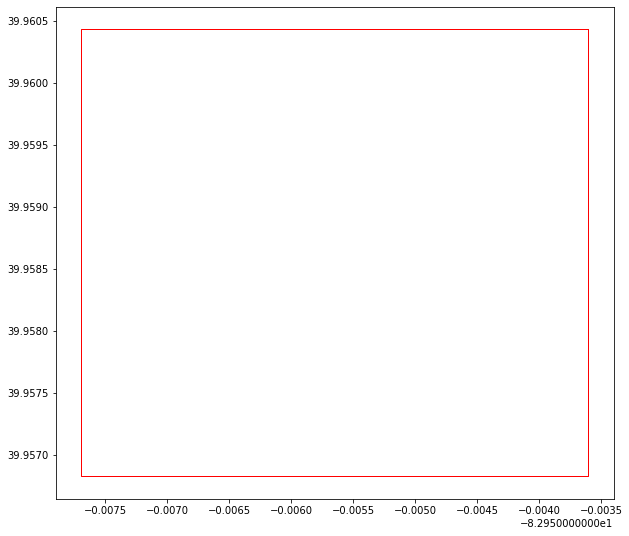

In [7]:
gdf.plot(edgecolor="red", facecolor="none", figsize=(10,10))

## Create interactive map

In [8]:
# Create a ipyleaflet map object centered on the image boundign box centroid.
m = Map(center=(rectangle.centroid.y, rectangle.centroid.x), zoom = 16, basemap=basemaps.OpenStreetMap.Mapnik)

# Create a temporary JPEG copy of the image so it can be displayed on the map (TIFFs not supported)
temp = Image.open(os.path.normpath(infile))
temp.save(tempfile)

# Create an ipyleaflet image overlay object.  The JPEG is in pixel space (not geographic coordinates) so we need to 
# map the image to the geographic bounding box we found earlier.
image = ImageOverlay(
    url=os.path.normpath(tempfile),
    bounds=((miny, minx), (maxy, maxx)),
    name = 'Georeferenced image'
)

# Delete the temporary file now that it is in memory
os.unlink(os.path.normpath(tempfile))

# Create an ipyleaflet GeoData object (a convenient way to display the GeoDataFrame)
geo_data = GeoData(geo_dataframe = gdf,
                   style={'color': 'red', 'fillColor': 'red', 'opacity':1, 'weight':2, 'fillOpacity':0.2},
                   name = 'Bounding box')

# Put it all on the map
m.add_layer(geo_data)
m.add_layer(image);
m.add_control(LayersControl())

# Display the map
m

Map(center=[39.958628013458295, -82.95565081619841], controls=(ZoomControl(options=['position', 'zoom_in_text'…